In [155]:
import torch
import torch.nn as nn
import numpy as np
import matplotlib.pyplot as plt
import pandas as pd

In [156]:
# Define LSTM Autoencoder
class LSTMAutoencoder(nn.Module):
    def __init__(self, seq_len, n_features, embedding_dim=64):
        super(LSTMAutoencoder, self).__init__()
        self.seq_len = seq_len
        self.encoder = nn.LSTM(n_features, embedding_dim, batch_first=True)
        self.decoder = nn.LSTM(embedding_dim, n_features, batch_first=True)

    def forward(self, x):
        x, (hidden, _) = self.encoder(x)
        h = hidden.repeat(x.size(1), 1, 1).transpose(0,1)
        x, (hidden, _) = self.decoder(h)
        return x


In [157]:
# Generate random sequence data
def generate_sequence_data(seq_len):
    return np.random.rand(seq_len, 1)

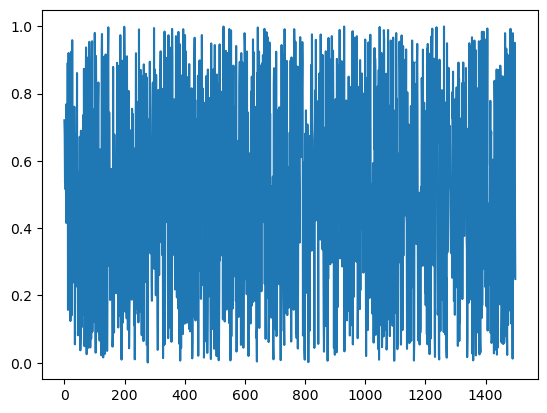

In [158]:
# Parameters
seq_len = 1500
n_features = 1
embedding_dim = 64
n_epochs = 10
learning_rate = 0.001

# Create datasets
random_data = generate_sequence_data(seq_len)
train_len = int(seq_len * 0.8)
train_data, test_data = random_data[:train_len], random_data[train_len:]

train_tensor = torch.tensor(train_data.reshape(1,-1,1), dtype=torch.float32).cuda()
test_tensor = torch.tensor(test_data.reshape(1,-1,1), dtype=torch.float32).cuda()

# Plot data
plt.plot(random_data)
plt.show()

In [159]:
# Model, loss function and optimizer
model = LSTMAutoencoder(seq_len, n_features, embedding_dim).cuda()
criterion = nn.L1Loss(reduction='none').cuda()
optimizer = torch.optim.Adam(model.parameters(), lr=learning_rate)

# Training
model.train()
for epoch in range(n_epochs):
    optimizer.zero_grad()
    output = model(train_tensor)
    loss = criterion(output, train_tensor)
    loss.mean().backward()
    optimizer.step()
    print(f'Epoch {epoch+1}, Loss: {loss.mean().item()}')

Epoch 1, Loss: 0.294357568025589
Epoch 2, Loss: 0.2855019271373749
Epoch 3, Loss: 0.2780762314796448
Epoch 4, Loss: 0.27175381779670715
Epoch 5, Loss: 0.26634180545806885
Epoch 6, Loss: 0.2618066072463989
Epoch 7, Loss: 0.2581535577774048
Epoch 8, Loss: 0.2555353343486786
Epoch 9, Loss: 0.2536546587944031
Epoch 10, Loss: 0.2525142729282379


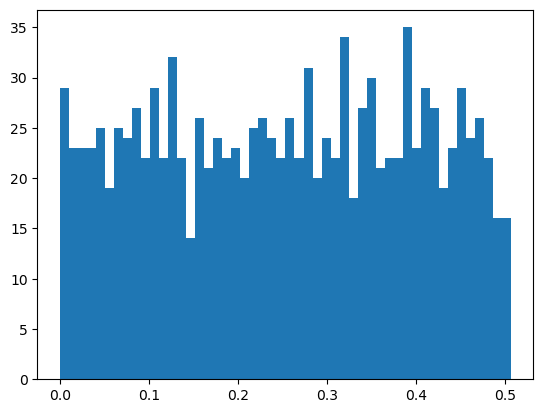

In [160]:
# Setting threshold using training loss distribution
model.eval()
with torch.no_grad():
    reconstructed = model(train_tensor)
    loss = criterion(reconstructed, train_tensor).cpu().numpy()
plt.hist(loss[0], bins=50)
plt.show()

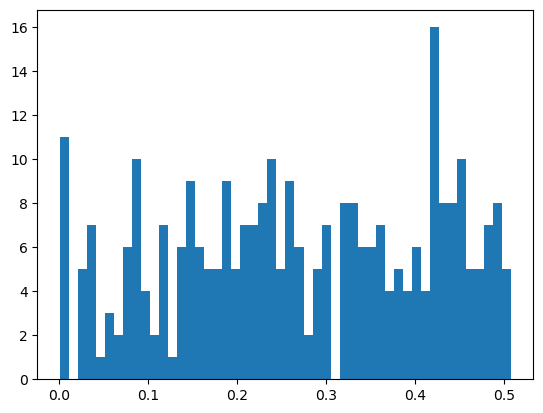

In [161]:
# Anomaly detection
THRESHOLD = 0.5

model.eval()
with torch.no_grad():
    reconstructed = model(test_tensor)
    loss = criterion(reconstructed, test_tensor).cpu().numpy()
    anomalies = loss > THRESHOLD

plt.hist(loss[0], bins=50)
plt.show()

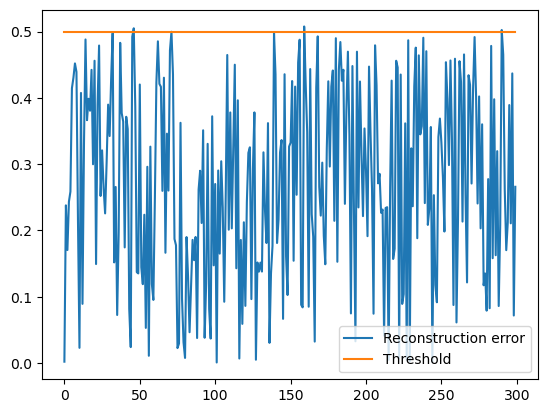

In [162]:
plt.plot(loss[0,...,0], label='Reconstruction error')
plt.plot(np.arange(loss.shape[1]), np.ones(loss.shape[1])*THRESHOLD, label='Threshold')
plt.legend()

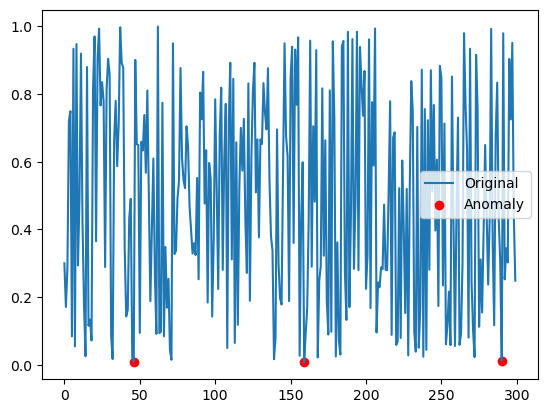

In [163]:
# Visualization

viz_sample = test_tensor[0, :, 0].cpu()
# plt.figure(figsize=(20,10))
plt.plot(viz_sample, label='Original')
anomaly_indices = np.where(anomalies[0,:,0])[0]
plt.scatter(anomaly_indices, viz_sample[anomaly_indices], c='red', label='Anomaly')
plt.legend()
plt.show()